### Import packages

In [40]:
import os
import glob
import numpy  as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import ipywidgets as widgets
import soundfile as sf
import yaml

### Choose file to inspect¶

In [11]:
directory='/Users/saroltagabulya/git/Orca/call_segments/'

folders=os.listdir(directory)
file=[]

dropdown=widgets.Dropdown(
    options=folders,
    description='CSV files:',
    disabled=False,
)

def dropdown_eventhandler(change):
    file.clear()
    file.append(change.new)
    print(change.new)
dropdown.observe(dropdown_eventhandler, names='value')
display(dropdown)

Dropdown(description='CSV files:', options=('.DS_Store', '.ipynb_checkpoints', '2017-02-04--10-14-06--00-16-35…

2020-12-15--23-21-29--00-40-00--A


### Read wav file names

In [14]:
folder_name = directory + file[0]
os.chdir(folder_name)
wavs=glob.glob('*.wav')
wavs

['2020-12-15--23-21-29--00-40-00--A_66243375_66444907.wav',
 '2020-12-15--23-21-29--00-40-00--A_94024651_94143925.wav',
 '2020-12-15--23-21-29--00-40-00--A_72145018_72305421.wav',
 '2020-12-15--23-21-29--00-40-00--A_109018800_109142187.wav',
 '2020-12-15--23-21-29--00-40-00--A_67954716_68349555.wav',
 '2020-12-15--23-21-29--00-40-00--A_110316607_110575720.wav',
 '2020-12-15--23-21-29--00-40-00--A_88557369_88713660.wav',
 '2020-12-15--23-21-29--00-40-00--A_17776329_18314746.wav',
 '2020-12-15--23-21-29--00-40-00--A_90661768_90745895.wav',
 '2020-12-15--23-21-29--00-40-00--A_21120120_21214716.wav',
 '2020-12-15--23-21-29--00-40-00--A_24341270_24526350.wav',
 '2020-12-15--23-21-29--00-40-00--A_47122378_47288014.wav',
 '2020-12-15--23-21-29--00-40-00--A_114214143_114333418.wav',
 '2020-12-15--23-21-29--00-40-00--A_112392503_112643390.wav',
 '2020-12-15--23-21-29--00-40-00--A_115679458_115934458.wav',
 '2020-12-15--23-21-29--00-40-00--A_9409188_9667180.wav',
 '2020-12-15--23-21-29--00-40-00

### Extract samplerate from metadata file

In [39]:
w=wavs[0]

yml_file=w[:-3] + 'yml'


with open(yml_file) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    metadata = yaml.load(file, Loader=yaml.FullLoader)
    

sample_rate=metadata['sample_rate']

    

### Define functions to open wav as spect

In [16]:
def open_wav(row, sample_rate):
    y, sr = librosa.load(row.call_wav, sr=sample_rate)
    return y, sr, row.call_wav

def wav_to_spect(y, sr, call_wav):
    
    if len(y)>0:
        # Convert to spectogram 
        Y = librosa.stft(y)
        Ydb = librosa.amplitude_to_db(abs(Y), ref=1)
        
        librosa.display.specshow(Ydb, cmap='seismic', sr=sr, x_axis='time', y_axis='hz')

        #plt.imshow(Ydb, aspect=0.3, origin='lower')
        plt.xlabel('time(samples)')
        plt.ylabel('Hz')

        # Save spectograms
        plt.savefig(call_wav[:-3] + 'png')
        plt.close()
    
        return Ydb
    
    else: 
        return 'Error with wav'


### Read metadata

In [5]:
try:
    wave_file=wave.open(file[0], "rb")
    sample_rate = wave_file.getframerate()
except:
    sample_rate=int(input('Please check sampling rate manually in the metadata file and set below in Hz! \n'))

Please check sampling rate manually in the metadata file and set below in Hz! 
100000


### Read in wav

In [6]:
y, sr = librosa.load(recording_name + '.wav', sr=sample_rate)

### Onsets & offsets in csv are in seconds => Convert to samples by multiplying them with the fs

second * fs = samples


In [7]:
time_stamps['onset_samples']=time_stamps.onset.apply(lambda x: int(round(x*sr)))
time_stamps['offset_samples']=time_stamps.offset.apply(lambda x: int(round(x*sr)))

### Function for cropping wav and saving

In [8]:
try:
    os.mkdir('./call_segments/' + recording_name + '_2')
    
except Exception as e:
    print(e)

[Errno 17] File exists: './call_segments/2017-02-04--10-14-06--00-16-35--BC_2'


In [9]:
def crop_call(row, y, sr, recording_name):
    call_filename= recording_name + '_' + str(row.onset_samples) + '_' + str(row.offset_samples) + '.wav'
    call=y[row.onset_samples: row.offset_samples]
    call_path='./call_segments/' + recording_name  + '_2' +'/' +  call_filename
    sf.write(call_path, call, sr) 
    return call_path

In [10]:
time_stamps['call_wav']=time_stamps.apply(lambda x: crop_call(x, y, sr, recording_name), axis=1)

In [19]:
call_file=time_stamps.call_wav[1]

In [20]:
y, sr = librosa.load(call_file, sr=sample_rate)

In [21]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y), ref=1)

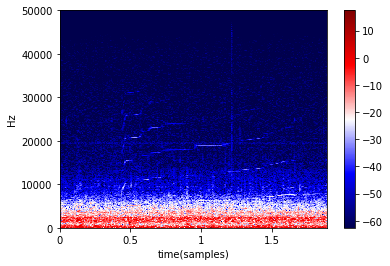

In [26]:
librosa.display.specshow(Ydb, cmap='seismic', sr=sr, x_axis='time', y_axis='hz')
plt.xlabel('time(samples)')
plt.ylabel('dBa relative to 1 uPa**2/Hz')
plt.colorbar()

### Function for converting wavs into spectrograms

In [30]:
time_stamps['spect']=time_stamps.apply(lambda x: wav_to_spect(*open_wav(x, sample_rate)), axis=1) 

### Save csv under new name

In [31]:
time_stamps.to_csv('call_data_' + recording_name + '_2'+ '.csv')